In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
import tensorflow as tf
from epi.SSSN import SSSN_sim, SSSN_sim_sigma_c0, SSSN_sim_sigma_c1, SSSN_sim_traj
#from epi.SSSN import SSSN_sim_tfp
from epi.SSSN import load_SSSN_variable
from epi.util import plot_T_x


neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "./"
ind = 1070

In [3]:
black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [6]:
lb = 0.0*np.ones((4,))
ub = 1.*np.ones((4,))
sigma = Parameter("sigma", 4, lb=lb, ub=ub)
parameters = [sigma]

# Define model
name = "SSSN"
model = Model(name, parameters)


E: 2 373/200
P: 2 258/200
S: 5 203/200
V: 3 217/200
E: 3 222/200
P: 5 231/200
S: 3 237/200
V: 12 200/200


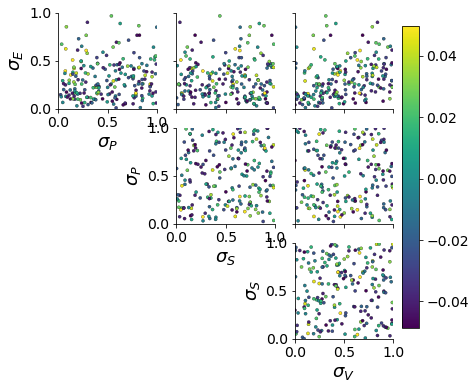

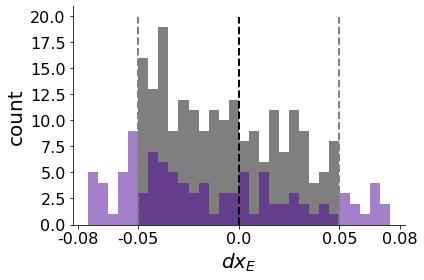

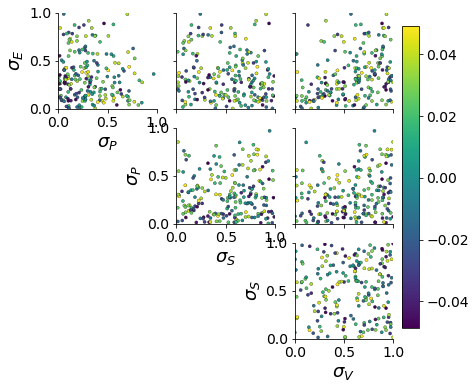

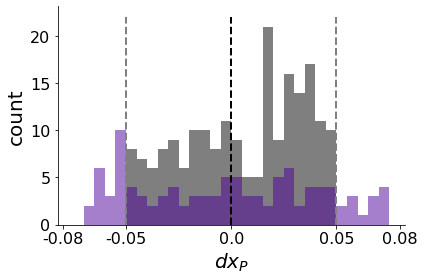

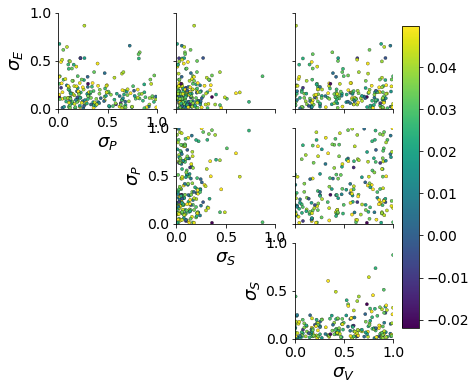

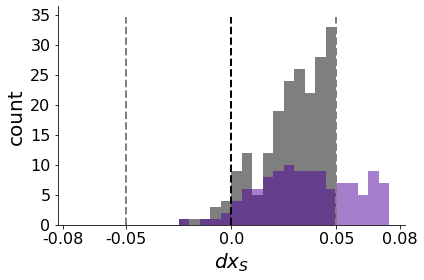

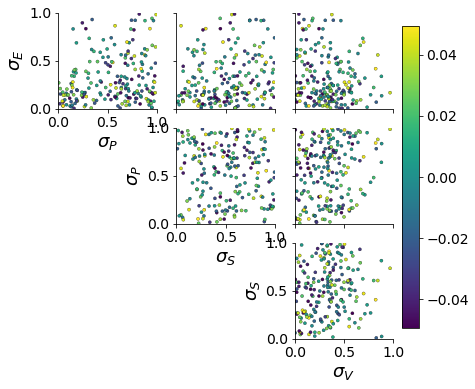

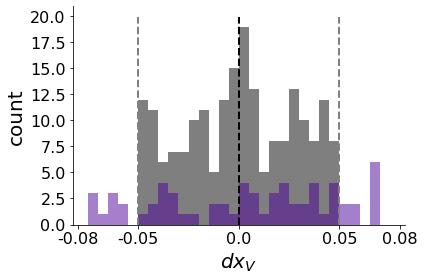

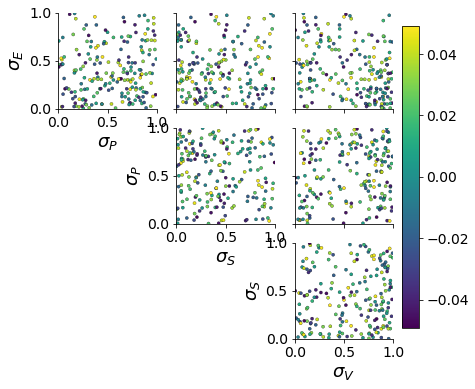

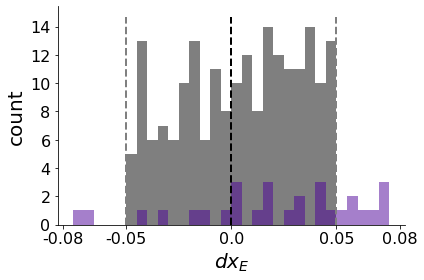

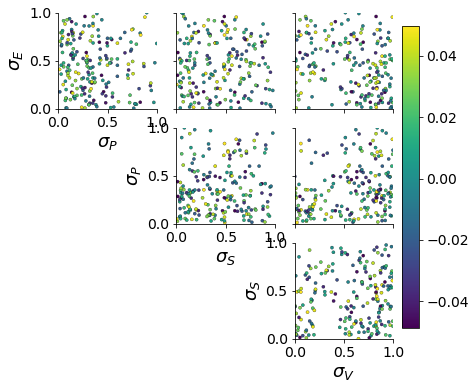

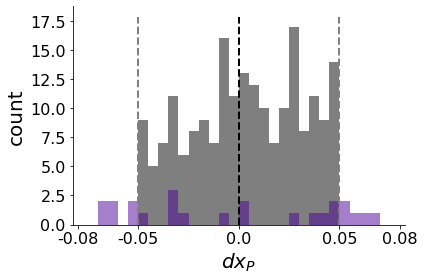

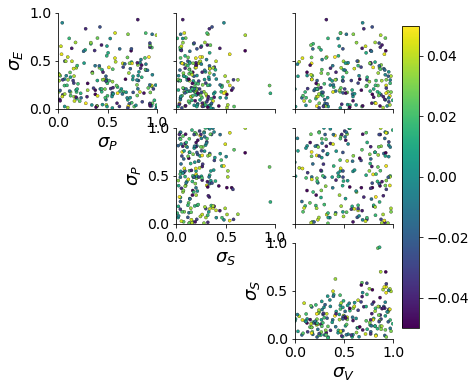

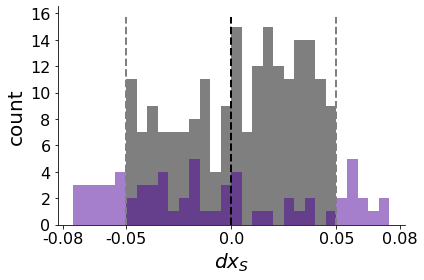

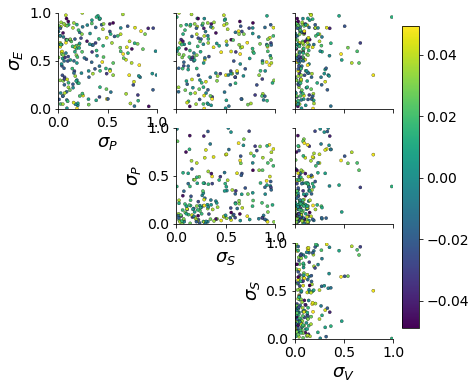

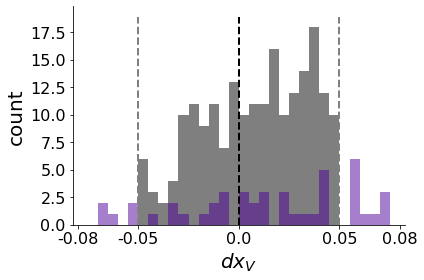

In [8]:
D = 4
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
def accept_inds(T_x, alpha, inc_std):
    neuron_ind = neuron_inds[alpha]
    return np.logical_and(-2*inc_std < T_x[:,neuron_ind], 
                          T_x[:,neuron_ind] < 2*inc_std)

alphas = ['E', 'P', 'S', 'V']
num_alphas = len(alphas)
num_keep = 200
num_plot = 200
M = 1000
zs = []
T_xs = []

inc_std = 0.025
contrasts = [0.,1.]

for contrast in contrasts:
    if contrast == 0.:
        def dr(sigma):
            x1 = tf.reduce_mean(SSSN_sim_sigma_c0(np.zeros((1,4)))[:,:,:4], axis=1)
            x2 = tf.reduce_mean(SSSN_sim_sigma_c0(sigma)[:,:,:4], axis=1)

            diff = x2 - x1
            T_x = tf.concat((diff, diff ** 2), axis=1)

            return T_x
    elif contrast == 1.:
        def dr(sigma):
            x1 = tf.reduce_mean(SSSN_sim_sigma_c1(np.zeros((1,4)))[:,:,:4], axis=1)
            x2 = tf.reduce_mean(SSSN_sim_sigma_c1(sigma)[:,:,:4], axis=1)

            diff = x2 - x1
            T_x = tf.concat((diff, diff ** 2), axis=1)

            return T_x
        
    
    model.set_eps(dr)
    zs_i = []
    T_xs_i = []
    for i in range(num_alphas):
        alpha = alphas[i]
        name = "V1_Circuit_%s_c=%.1f" % (alpha, contrast)
        #M = Ms[k][i]
        neuron_ind = neuron_inds[alpha]
        fontsize = 30

        num_found = 0
        z = None
        T_x = None
        count = 0
        while (num_found < num_keep):
            count += 1
            _z = np.zeros((M, D))
            for j in range(D):
                _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
            _T_x = model.eps(_z).numpy()

            inds = accept_inds(_T_x, alpha, inc_std)
            _z = _z[inds, :]
            _T_x = _T_x[inds, :]
            num_found += _z.shape[0]
            
            if (z is None):
                z = _z
                T_x = _T_x
            else:
                z = np.concatenate((z, _z), axis=0)
                T_x = np.concatenate((T_x, _T_x), axis=0)
            print('%s: %d %d/%d\r' % (alpha, count, num_found, num_keep), end='')

        num_found = z.shape[0]
        
        # reduce to num_keep
        z = z[:num_keep]
        T_x = T_x[:num_keep]
        zs_i.append(z)
        T_xs_i.append(T_x)

        _dv = T_x[:,neuron_ind]
        z_labels = [r'$\sigma_E$', r'$\sigma_P$', r'$\sigma_S$', r'$\sigma_V$']
        fig = pairplot(z[:num_plot], np.arange(4), z_labels, figsize=(6,6),
                       fontsize=18, lb=lb, ub=ub, c=_dv)
        plt.savefig(figdir + name + '_ABC_z.png')
        
        T_x_sim = model.eps(z).numpy()
        
        plot_T_x(T_x[:,neuron_ind], T_x_sim[:,neuron_ind], x_mean=0., x_std=inc_std, xmin=-3*inc_std, xmax=3.*inc_std, xlabel=r'$dx_%s$' % alpha, fontsize=20)
        plt.tight_layout()
        plt.savefig(figdir + name + '_ABC_Tx.png')
        print('')
        
    
    zs.append(zs_i)
    T_xs.append(T_xs_i)

In [12]:
"""num_plot = 500
fontsize = 14
z_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']
fig = pairplot(z[:num_plot], np.arange(4), z_labels,
               fontsize=22,
               lb=lb, ub=ub)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')"""

"num_plot = 500\nfontsize = 14\nz_labels = [r'$dh_E$', r'$dh_P$', r'$dh_S$', r'$dh_V$']\nfig = pairplot(z[:num_plot], np.arange(4), z_labels,\n               fontsize=22,\n               lb=lb, ub=ub)\nplt.savefig(figdir + 'SV_flip_ABC_z.png')\n               #c_label='prod')"

In [9]:
hs = z + H
x_t = SSSN_sim_traj(hs).numpy()
print(x_t.shape)
dt = 0.00025
t = dt*np.arange(101)
for j in range(10):
    plt.figure()
    for i in range(4):
        plt.plot(t, x_t[j,0,i,:].T, c=colors[i])
    plt.ylim([0, .8])
    plt.show()

NameError: name 'H' is not defined